# Solving meta decision trees

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.5)
import itertools as it
from collections import Counter, defaultdict, deque
from toolz.curried import memoize, get
from random import choice
from tqdm import tqdm_notebook as tqdm

In [2]:
# Plotting decision trees
from IPython.display import display
from meta_tree import MetaTree
from IPython.display import Image
COLOR = {None: 'grey', np.inf: 'grey', 1: '#dd4444', 0: '#5555ee'}
from graphviz import Digraph
def draw_tree(state):
    dot = Digraph()
    for x, ys in enumerate(mt.tree):
        c = COLOR[state[x]]
        dot.node(str(x), style='filled', color=c)
        for y in ys:
            dot.edge(str(x), str(y))
    display(dot)

In [124]:
from scipy.io import loadmat
M = loadmat('selected_computations.mat')

FileNotFoundError: [Errno 2] No such file or directory: 'selected_computations.mat'

In [123]:
np.mean([tr.get('score') for tr in data][:-1])

12.375

In [59]:
import json
with open('results/selected_computations.json') as f:
    C = json.load(f)
len(C[0][0])

1

In [3]:
def sort_tree(mt, state):
    """Breaks symmetry between belief states.
    
    This is done by enforcing that the knowldge about states at each
    depth be sorted by [0, 1, UNKNOWN]
    """
    state = list(state)
    for i in range(len(mt.tree) - 1, -1, -1):
        if not mt.tree[i]:
            continue  # 
        c1, c2 = mt.tree[i]
        if not (mt.subtree(state, c1) <= mt.subtree(state, c2)):
            diff = c2 - c1
            for j in range(c1, c2):
                state[j], state[j+diff] = state[j+diff], state[j]
    return tuple(state)

def solve(mdp, hash_state=None, actions=None):
    """Returns Q, V, pi, and computation data for an mdp."""
    if actions is None:
        actions = mdp.actions
    if hash_state is None:
        hash_state = lambda s: sort_tree(mt, s)
    info = {  # track number of times each function is called
        'q': 0,
        'v': 0
    }

    @memoize
    def Q(s, a):
        info['q'] += 1
        return sum(p * (r + V(s1)) for p, s1, r in mdp.results(s, a))

    def hash_key(args, kwargs):
        s = args[0]
        if s is None:
            return s
        else:
            return hash_state(args[0])

    if hash_state is None:
        hash_key = None
        
    @memoize(key=hash_key)
    def V(s):
        if s is None:
            return 0
        info['v'] += 1
        return max(Q(s, a) for a in actions(s))
    
    @memoize
    def pi(s):
        return max(actions(s), key=lambda a: Q(s, a))
    
    return Q, V, pi, info

mt = MetaTree(2, 2, cost=-0.1)
Q, V, pi, info = solve(mt)  # note: no computation actually happens here.
print('Value:', V(mt.init))  # calling V(mt.init) runs the algorithm
print('Computations:', info)

Value: 1.80625
Computations: {'q': 513, 'v': 171}


In [4]:
def VOC1(mt, state, action):
    val_term_next = sum(p * (r + mt.term_value(s1))
        for p, s1, r in mt.results(state, action))
    return val_term_next - mt.term_value(state)

VOC1(mt, mt.init, 6)

0.1499999999999999

In [5]:
def path_value(state, path):
    def rec(i, s, v, p):
        if i == len(path):
            yield p, v
            return
        s = self.tree[s][path[i]]
        r = state[s]
        if r is self.unknown:
            for o in self.outcomes:
                yield from rec(i+1, s, v+o, p * self.outcome_prob)
        else:
            yield from rec(i+1, s, v+r, p)
    return expect(rec(0, 0, 0, 1))

In [6]:
 def V(s):
        r = state[s]
        if r is self.unknown:
            r = self.expected_outcome
        future_reward = max((V(s1) for s1 in self.tree[s]), default=0)
        return r + future_reward

In [7]:
def paths(mt, state, n):
    def rec(i, path):
        if mt.tree[i]:
            for child in mt.tree[i]:
                yield from rec(child, path + [state[i]])
        else:
            yield path + [state[i]]
    return rec(n, [])


In [8]:
def outcomes(mt, state, n):
    d = []
    if state[n] is mt.unknown:
        for r in mt.outcomes:
            d.append((mt.outcome_prob, r))
    else:
        d.append((1, state[n]))
    return d

def cross(d1, d2, f):
    outcomes = Counter()
    for ((p1, o1), (p2, o2)) in it.product(d1, d2):
        outcomes[f(o1, o2)] += p1 * p2
    return [(p, v) for v, p in outcomes.items()]

-> [(0.25, 1), (0.75, 2)]


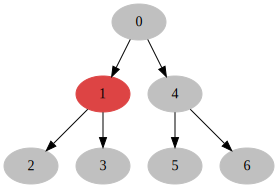

In [9]:
def V_dist(mt, state, n):
    def rec(p, s):
        if mt.tree[s]:
            # assume 2 branch
            child_vs = [list(rec(p * 0.5, s1)) for s1 in mt.tree[s]]
            v_dist = cross(*child_vs, f=max)
            r_dist = outcomes(mt, state, s)
#             print(s, r_dist, v_dist, child_vs)
            yield from cross(r_dist, v_dist, f=lambda x, y: x+y)
        else:
            yield from outcomes(mt, state, s)
    return rec(1, n)

state = list(mt.init)
state[1] = 1
print('->', list(V_dist(mt, state, 1)))
draw_tree(state)

In [10]:
def VPI(mt, state, action):
    assert action > 0
    choices = list(mt.tree[0])
    vals = [mt.tree_V(state, s) for s in choices]
    print('vals = {}'.format(vals))
    
    best_choice, best_val = max(((i, v) for i, v in enumerate(vals)), key=get(1))
    best_node = choices[best_choice]
    assert len(choices) is 2  # assuming binary tree
    relevant_node = choices[0] if action < choices[1] else choices[1]
    
    benefit = 0
    if relevant_node is best_node:
        vals.pop(best_choice)
        other_node, other_val = max(((i, v) for i, v in enumerate(vals)), key=get(1))
        print('other', other_node, other_val)
#         other_val = 1.25
        for p, v in V_dist(mt, state, relevant_node):
            benefit += p * max(0, other_val - v)
    else:
        for p, v in V_dist(mt, state, relevant_node):
            benefit += p * max(0, v - best_val)

    return benefit
        

mt = MetaTree(2, 3, cost=-0.1)

state = list(mt.init)
# state[1] = 1
# state[4] = 1
state = tuple(state)
# draw_tree(state)
print(VPI(mt, state, 1))
print(VPI(mt, state, 8))

vals = [1.5, 1.5]
other 0 1.5
0.109375
vals = [1.5, 1.5]
0.703125


In [11]:
from meta_tree import Labeler
mt = MetaTree(2, 3, outcomes=(0,1), cost=-0.1)
Q, V, pi, info = solve(mt)
states = it.product((mt.unknown, *mt.outcomes), repeat=len(mt.tree))
non_sym = list(set(tqdm((sort_tree(mt, s) for s in states),
                   total=(len(mt.outcomes) + 1) ** len(mt.tree))))
Qmat = np.full((len(non_sym), len(mt.tree)+1), np.nan)

In [12]:
state_labeler = Labeler()

states = []
actions = []
Q_star = []
features = []
pi_hat = []
pi_mat = []
for i, s in enumerate(tqdm(non_sym)):
    acts = []
    if s is None:
        continue
    for a in mt.actions(s):
        state_labeler(s)
        states.append(s)
        actions.append(a)
        Q_star.append(Q(s, a))
        acts.append((Q(s, a), a))
        if a is mt.term_action:
            features.append([0, 1, mt.term_value(s)])
        else:
            features.append([VOC1(mt, s, a), 1, mt.term_value(s)])
    pi_hat.append(max(acts)[1])
    pi_mat.append(pi(s))

In [13]:
def rms(y_hat, y):
    return ((y_hat - y) ** 2).mean() ** 0.5

y = np.array(Q_star)
X = np.array(features)

beta = np.linalg.inv(X.T @ X) @ X.T @ y
y_hat = X @ beta
print(beta)
print(rms(y_hat, y))
print(rms(y.mean(), y))

[ 0.90795638  0.13859968  0.96662686]
0.0720605064123
0.597870340415


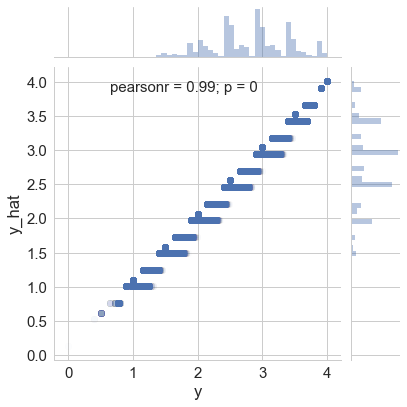

In [15]:
# df['pi_star'] = df.state.apply(pi)
voc, vpi, term = X.T
err = y - y_hat
df = pd.DataFrame({'voc': voc, 'vpi': vpi, 'term': term, 'err': err, 'y': y, 'y_hat': y_hat,
                   'state': states, 'action': actions})
df = df.round(4)
sns.jointplot('y', 'y_hat', data=df, alpha=.01)
# sns.jointplot('y', 'y_hat', data=df.query('pi_hat == 7'), kind='kde')

In [19]:
np.unique(pi_hat)

array([ 1,  2,  4,  5,  7,  8,  9, 11, 12, 14, 15])

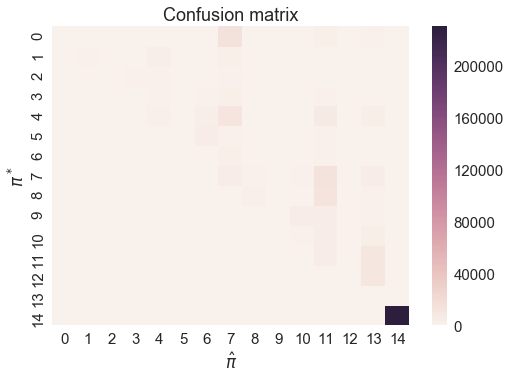

In [26]:
pi_hat = np.array(pi_hat)
pi_mat = np.array(pi_mat)

from sklearn.metrics import confusion_matrix
C = confusion_matrix(pi_mat, pi_hat)
with sns.plotting_context(font_scale=1.5):
    # sns.heatmap(C[:-1, :-1])
    sns.heatmap(C)
    plt.ylabel(r'$\pi^*$')
    plt.xlabel(r'$\hat\pi$')
    plt.title('Confusion matrix')

In [29]:
((pi_hat == mt.term_action) == (pi_mat == mt.term_action)).mean()

0.41741946738874858

In [309]:
df['pi_hat'] = df.groupby('state').apply(
    lambda dd: dd.action[dd.y.argmax()]
)

In [28]:
def run_episode(mdp, pi, s=None):
    """Runs a single random episode of an mdp with policy pi."""
    if s is None:
        s = mdp.init
    acts = []
    states = []
    reward = 0
    while True:
        a = pi(s)
        states.append(s)
        p, s, r = choice(mdp.results(s, a))
        acts.append(a)
        reward += r
        if a is mdp.term_action:
#             draw_tree(states[-1])
            return acts, reward

def run_many(mt, pi, N=1000):
    for _ in range(N):
        actions, reward = run_episode(mt, pi)
        yield reward 

# @memoize
# S = None
def pi_hat(s):
    global S
    S = s
    dd = df.query('state == @s')
    return dd.action[dd.y_hat.argmax()]

def Q_hat(s, a):
    x = [VOC1(mt, s, a), VPI(mt, s,a), mt.term_value(s)]
    return x @ beta

def phi(s, a):
    return [VOC1(mt, s, a), VPI(mt, s,a), mt.term_value(s)]

run_episode(mt, pi_hat)
# draw_tree(S)
# Q_hat(mt.init, 8)
# print(phi(mt.init, 8))
# print(phi(mt.init, 1))

ValueError: attempt to get argmax of an empty sequence

In [269]:
beta

array([ 0.92436021,  0.11080306,  0.99954387])

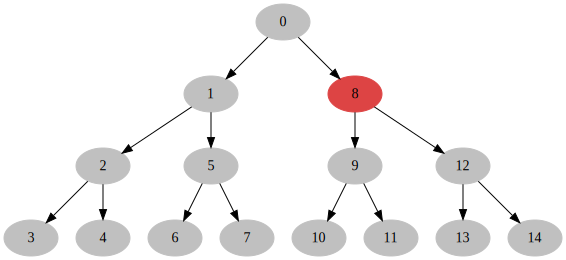

In [255]:
draw_tree(S)


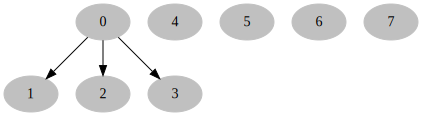

In [129]:
mt = MetaTree(3, 1)
draw_tree(mt.init)